## 学習済みCNNを使用する

#### VGGモデルの読み込み

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### 学習済みのCNNから特徴抽出

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/Kenji/documents/keras/Keras-training/data/cats_and_dogs/small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150,150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
100Found 1000 images belonging to 2 classes.
50Found 1000 images belonging to 2 classes.
50

#### 全結合分類器の定義とtraining

In [5]:
from keras import layers, models, optimizers

model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 873us/step - loss: 0.5726 - acc: 0.6910 - val_loss: 0.4013 - val_acc: 0.8440
Epoch 2/30
2000/2000 [==============================] - 1s 408us/step - loss: 0.3874 - acc: 0.8340 - val_loss: 0.3313 - val_acc: 0.8710
Epoch 3/30
2000/2000 [==============================] - 1s 405us/step - loss: 0.3164 - acc: 0.8735 - val_loss: 0.2945 - val_acc: 0.8900
Epoch 4/30
2000/2000 [==============================] - 1s 408us/step - loss: 0.2843 - acc: 0.8795 - val_loss: 0.2826 - val_acc: 0.8890
Epoch 5/30
2000/2000 [==============================] - 1s 425us/step - loss: 0.2526 - acc: 0.9015 - val_loss: 0.2672 - val_acc: 0.8970
Epoch 6/30
2000/2000 [==============================] - 1s 447us/step - loss: 0.2309 - acc: 0.9105 - val_loss: 0.2581 - val_acc: 0.8990
Epoch 7/30
2000/2000 [==============================] - 1s 406us/step - loss: 0.2141 - acc: 0.9140 - val_loss: 0.2512 - val_acc: 0.8990


#### Accuracy と Lossのplot

<IPython.core.display.Javascript object>


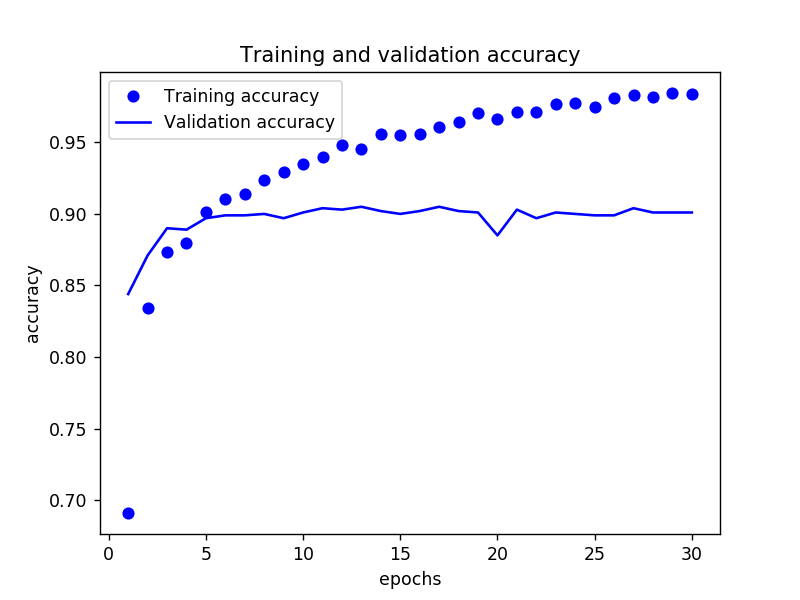

Text(0.5,1,'Training and validation accuracy')

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure()
plt.plot(range(1, len(acc)+1), acc, 'bo', label='Training accuracy')
plt.plot(range(1, len(acc)+1), val_acc, 'b', label='Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and validation accuracy')


<IPython.core.display.Javascript object>


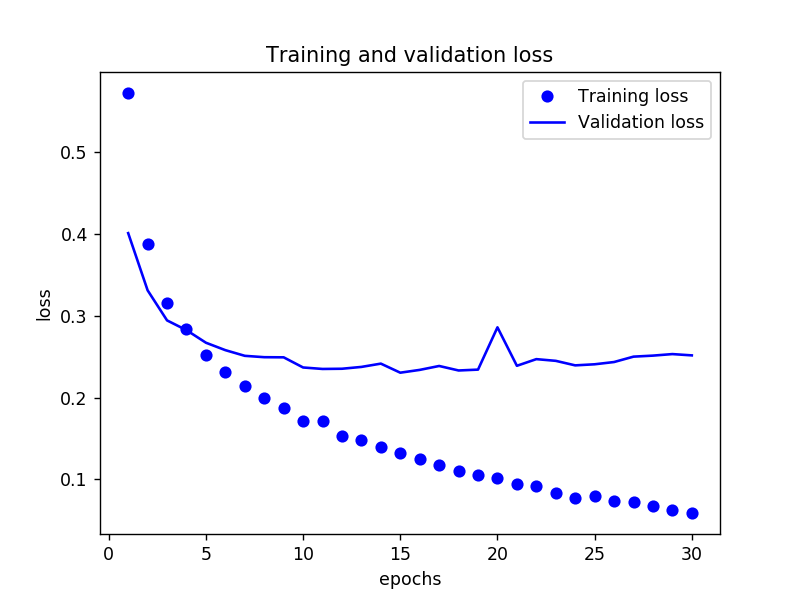

Text(0.5,1,'Training and validation loss')

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(1, len(loss)+1), loss, 'bo', label='Training loss')
plt.plot(range(1, len(loss)+1), val_loss, 'b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training and validation loss')


#### Enable data augmentation by integrating VGG with fully connected layers since overfitting is still there

In [17]:
from keras import models, layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#freeze conv layers
conv_base.trainable = False

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 16,878,145
Trainable params: 2,163,457
Non-trainable params: 14,714,688
_________________________________________________________________


In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary')

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50,
                              verbose=1)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 26s 258ms/step - loss: 0.5432 - acc: 0.7628 - val_loss: 0.4157 - val_acc: 0.8510
Epoch 2/30
100/100 [==============================] - 20s 204ms/step - loss: 0.4515 - acc: 0.8009 - val_loss: 0.3506 - val_acc: 0.8550
Epoch 3/30
100/100 [==============================] - 20s 204ms/step - loss: 0.4147 - acc: 0.8109 - val_loss: 0.3156 - val_acc: 0.8690
Epoch 4/30
100/100 [==============================] - 21s 206ms/step - loss: 0.3766 - acc: 0.8284 - val_loss: 0.2998 - val_acc: 0.8710
Epoch 5/30
100/100 [==============================] - 20s 205ms/step - loss: 0.3572 - acc: 0.8528 - val_loss: 0.2979 - val_acc: 0.8780- acc: 0.853
Epoch 6/30
100/100 [==============================] - 22s 219ms/step - loss: 0.3471 - acc: 0.8491 - val_loss: 0.2777 - val_acc: 0.8800
Epoch 7/30
100/100 [==============================] - 21s 205ms/step - loss: 0.3371 - acc: 0.8

<IPython.core.display.Javascript object>


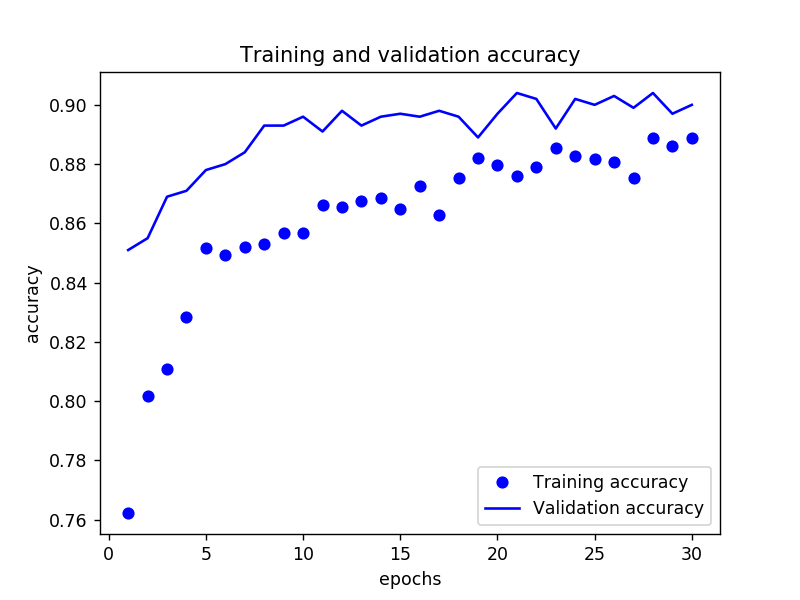

Text(0.5,1,'Training and validation accuracy')

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure()
plt.plot(range(1, len(acc)+1), acc, 'bo', label='Training accuracy')
plt.plot(range(1, len(acc)+1), val_acc, 'b', label='Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and validation accuracy')


<IPython.core.display.Javascript object>


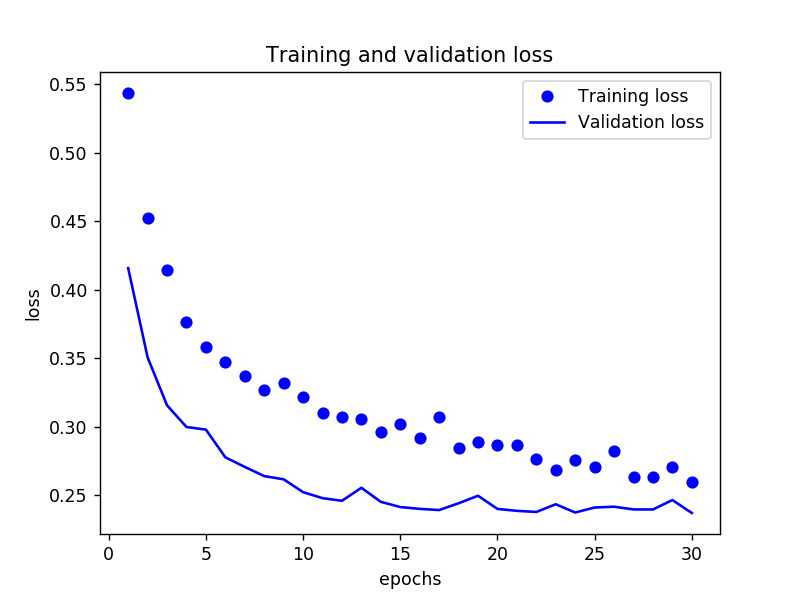

Text(0.5,1,'Training and validation loss')

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(1, len(loss)+1), loss, 'bo', label='Training loss')
plt.plot(range(1, len(loss)+1), val_loss, 'b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training and validation loss')


In [1]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:95% !important; }</style>")) 